Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.datasets import reuters
from keras import regularizers
from itertools import islice
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Data ingestion

In [ ]:
NUM_WORDS = 10000

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=NUM_WORDS)

2110848/2110848 [==============================] - 1s 0us/step


In [ ]:
print("Lenght X_train:", len(X_train))
print("Lenght X_test:", len(X_test))

print("Lenght y_train:", len(y_train))
print("Lenght y_test:", len(y_test))

Lenght X_train: 8982
Lenght X_test: 2246
Lenght y_train: 8982
Lenght y_test: 2246


In [ ]:
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [ ]:
print(y_train[0])

3


In [ ]:
words_dict = reuters.get_word_index()
limited_words_dict = dict(islice(words_dict.items(), 5))
print(limited_words_dict)

550378/550378 [==============================] - 0s 1us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796}


In [ ]:
reversed_words_dict = dict([(value, key) for (key, value) in words_dict.items()])
decoded_dict = " ".join([reversed_words_dict.get(i - 3, '?') for i in X_train[0]])
decoded_dict

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [ ]:
decoded_y = reuters.get_label_names()

print("Labels in Reuters:")
for index, label_name in enumerate(decoded_y):
    print(f"{index + 1}. {label_name}")

Labels in Reuters:
1. cocoa
2. grain
3. veg-oil
4. earn
5. acq
6. wheat
7. copper
8. housing
9. money-supply
10. coffee
11. sugar
12. trade
13. reserves
14. ship
15. cotton
16. carcass
17. crude
18. nat-gas
19. cpi
20. money-fx
21. interest
22. gnp
23. meal-feed
24. alum
25. oilseed
26. gold
27. tin
28. strategic-metal
29. livestock
30. retail
31. ipi
32. iron-steel
33. rubber
34. heat
35. jobs
36. lei
37. bop
38. zinc
39. orange
40. pet-chem
41. dlr
42. gas
43. silver
44. wpi
45. hog
46. lead


In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results


X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

print(f'X_train sample : {X_train[0]}')
print(f'X_test sample : {X_test[0]}')

X_train sample : [0. 1. 1. ... 0. 0. 0.]
X_test sample : [0. 1. 1. ... 0. 0. 0.]


In [ ]:
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')

X_train shape : (8982, 10000)
X_test shape : (2246, 10000)


In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

print(f'one_hot_train_labels sample : {one_hot_train_labels[0]}')

one_hot_train_labels sample : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, one_hot_train_labels, test_size=0.25, random_state=42)

print("x_val ", X_val.shape)
print("y_val ", y_val.shape)

print("X_train_val ", X_train_val.shape)
print("y_train_val ", y_train_val.shape)

x_val  (2246, 10000)
y_val  (2246, 46)
X_train_val  (6736, 10000)
y_train_val  (6736, 46)


In [ ]:
def count_label_occurrences(labels):
    unique_labels, occurrences = np.unique(labels, return_counts=True)
    return dict(zip(unique_labels, occurrences))

train_occurrences = count_label_occurrences(y_train_val)
val_occurrences = count_label_occurrences(y_val)

print("Occurrences of labels in training set:", train_occurrences)
print("Occurrences of labels in validation set:", val_occurrences)

Occurrences of labels in training set: {0.0: 303120, 1.0: 6736}
Occurrences of labels in validation set: {0.0: 101070, 1.0: 2246}


Class distribution

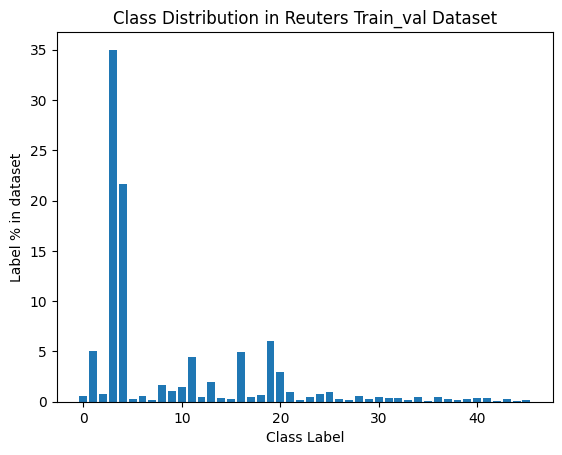

In [ ]:
unique_classes_train = np.sum(y_train_val, axis=0) / y_train_val.shape[0] * 100

plt.bar(np.arange(len(unique_classes_train)), unique_classes_train)
plt.xlabel('Class Label')
plt.ylabel('Label % in dataset')
plt.title('Class Distribution in Reuters Train_val Dataset')

plt.show()

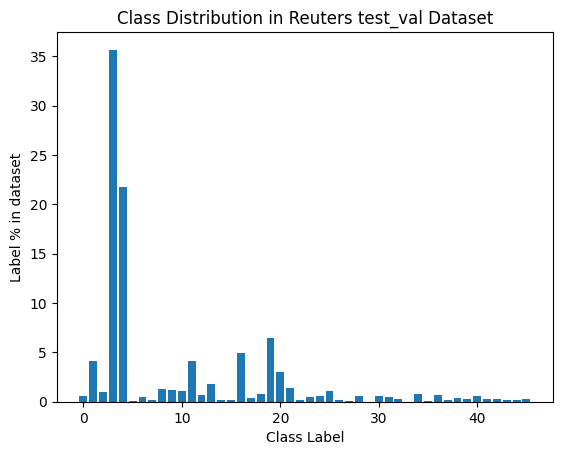

In [ ]:
unique_classes_test = np.sum(y_val, axis=0) / y_val.shape[0] * 100

plt.bar(np.arange(len(unique_classes_test)), unique_classes_test)
plt.xlabel('Class Label')
plt.ylabel('Label % in dataset')
plt.title('Class Distribution in Reuters test_val Dataset')

plt.show()

Building the network

In [ ]:
def create_model(optimizer='adam', activation='relu', epochs=8, batch_size=256):
    model = Sequential()
    model.add(Dense(128, activation=activation, input_shape=(10000,), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(64, activation=activation, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(32, activation=activation, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(16, activation=activation, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(46, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

GridSearchCV

In [ ]:
param_grid = {
    'build_fn': [create_model],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [8, 16],
    'batch_size': [256, 512]
}

grid = GridSearchCV(estimator=KerasClassifier(verbose=0),
                    param_grid=param_grid, cv=KFold(n_splits=3), verbose=1)

grid_result = grid.fit(X_train_val, y_train_val)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best: 0.735451 using {'batch_size': 256, 'build_fn': <function create_model at 0x7921d3ebecb0>, 'epochs': 16, 'optimizer': 'rmsprop'}


Best parameters

In [ ]:
best_activation = 'relu'
best_optimizer = 'rmsprop'
best_epochs = 16
best_batch_size = 256

best_model = create_model(activation=best_activation, optimizer=best_optimizer, epochs=best_epochs, batch_size=best_batch_size)

history = best_model.fit(X_train_val, y_train_val, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_val, y_val))

test_results = best_model.evaluate(X_test, one_hot_test_labels)
print("*" * 100)
print("Test Results: Loss and Accuracy")
print("Results:", test_results)

training_history_dict = history.history
print("Training History Keys:", training_history_dict.keys())

Epoch 1/16
27/27 [==============================] - 2s 30ms/step - loss: 3.1525 - accuracy: 0.4170 - val_loss: 2.3488 - val_accuracy: 0.5512
Epoch 2/16
27/27 [==============================] - 0s 13ms/step - loss: 2.0297 - accuracy: 0.6038 - val_loss: 1.9908 - val_accuracy: 0.6198
Epoch 3/16
27/27 [==============================] - 0s 15ms/step - loss: 1.6536 - accuracy: 0.6891 - val_loss: 1.7157 - val_accuracy: 0.6888
Epoch 4/16
27/27 [==============================] - 0s 14ms/step - loss: 1.4063 - accuracy: 0.7372 - val_loss: 1.6433 - val_accuracy: 0.6915
Epoch 5/16
27/27 [==============================] - 0s 13ms/step - loss: 1.2308 - accuracy: 0.7743 - val_loss: 1.5177 - val_accuracy: 0.7266
Epoch 6/16
27/27 [==============================] - 0s 12ms/step - loss: 1.0897 - accuracy: 0.8116 - val_loss: 1.5512 - val_accuracy: 0.7204
Epoch 7/16
27/27 [==============================] - 0s 13ms/step - loss: 0.9922 - accuracy: 0.8308 - val_loss: 1.4421 - val_accuracy: 0.7569
Epoch 8/16
27

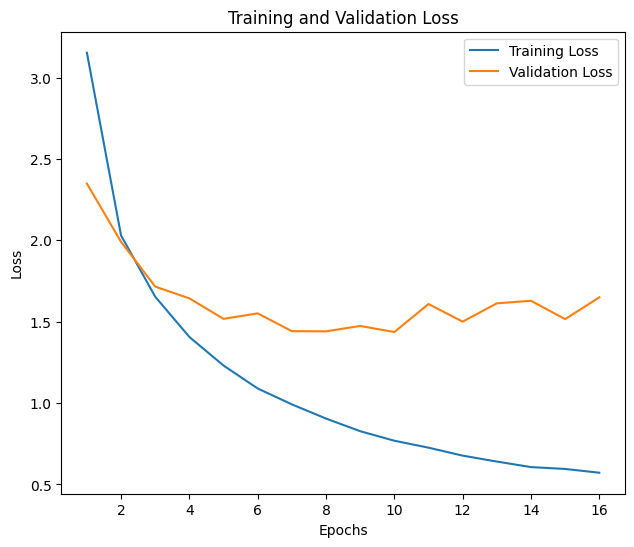

In [ ]:
epochs_range = range(1, best_epochs + 1)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_history_dict['loss'], label='Training Loss')
plt.plot(epochs_range, training_history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

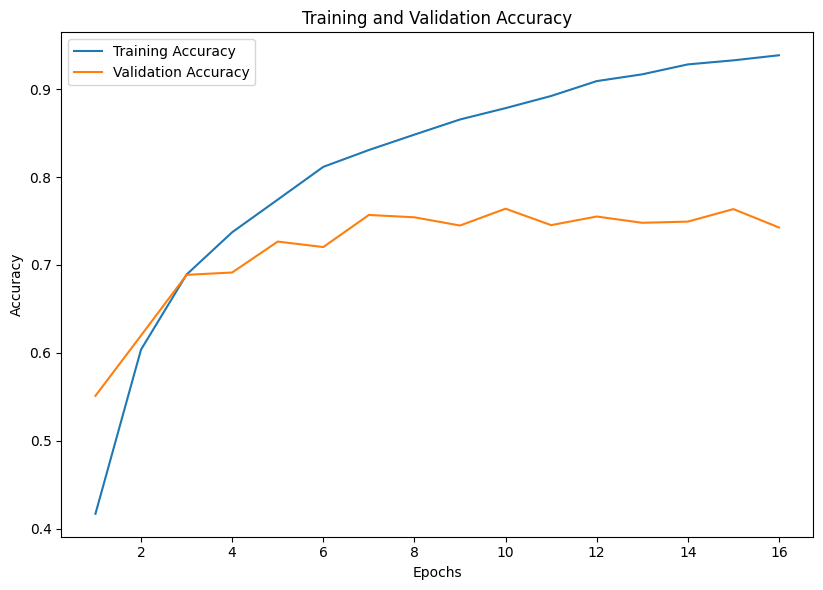

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_history_dict['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, training_history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Model optimization

In [ ]:
y_true = np.argmax(one_hot_test_labels, axis=1)
y_pred_probabilities = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

71/71 [==============================] - 0s 3ms/step
Accuracy: 0.7235
Precision: 0.7367
Recall: 0.7235
F1-Score: 0.7133

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.55      0.79      0.65       105
           2       0.67      0.50      0.57        20
           3       0.89      0.94      0.92       813
           4       0.92      0.74      0.82       474
           5       0.00      0.00      0.00         5
           6       0.92      0.79      0.85        14
           7       1.00      0.33      0.50         3
           8       0.62      0.55      0.58        38
           9       0.50      0.52      0.51        25
          10       0.94      0.57      0.71        30
          11       0.50      0.72      0.59        83
          12       0.33      0.08      0.12        13
          13       0.45      0.35      0.39        37
          14       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13